# Project 5: Classifying Point Clouds with PointNet

For this project, we are going to build deep learning architectures to classify point clouds that were extracted from self-driving car LiDAR scans.

Basic learning objectives of this project:
* Construct the basic pipeline used for point cloud classification
* Analyze the results from our model and look for potential points of improvement
* Understand the limitations of the model and improve it using positional encodings

## Setup

In [2]:
import sys
sys.path.insert(0, 'src')

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from vision.utils import verify

In [4]:
device = torch.device('cpu')
# If you have an NVIDIA GPU with at least 2 GB of VRAM, set this to True
use_cuda = False
# If you have an Apple Silicon Mac, set this to True
use_apple_silicon = False
if torch.cuda.is_available():
    if use_cuda:
        device = torch.device('cuda')
        print("CUDA-compatible NVIDIA GPU enabled.")
    else:
        print("CUDA-compatible NVIDIA GPU detected. Consider setting use_cuda to True.")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    if use_apple_silicon:
        device = torch.device('mps')
        print("Apple Silicon GPU enabled.")
    else:
        print("Apple Silicon GPU detected. Consider setting use_apple_silicon to True.")
        

print("Using device: %s" % str(device))

Apple Silicon GPU detected. Consider setting use_apple_silicon to True.
Using device: cpu


Lets take a second to visualize a few point clouds that we are going to train our model on. You might need to rotate the visualization before you can actually see the object being represented by the points. See if you can make out this pedestrian's arms, legs, and head.

In [5]:
from vision.utils import plot_cloud_from_file

plot_cloud_from_file('data/sweeps/PEDESTRIAN/11.txt')

## Part 1: Data Loading

The first order of business we're going to take care of is writing a PyTorch dataset that will load in the data we'll be using to train and test our model. We have a total of 20 different classes that all found under the `data/sweeps` folder and each class has been split into a training and testing set. We will write a class that will load the appropriate data given the split we pass in (i.e. train/test split).

**TODO 1:** complete `part1_dataloader.py`

In [6]:
from vision.part1_dataloader import Argoverse
from torch.utils.data import DataLoader
from tests.test_part1 import (
    test_dataset_length, 
    test_unique_values, 
    test_get_points_from_file, 
    test_pad_points, 
    test_class_values
)

In [7]:
print("test_dataset_length(): ", verify(test_dataset_length))
print("test_unique_values(): ", verify(test_unique_values))
print("test_get_points_from_file(): ", verify(test_get_points_from_file))
print("test_pad_points(): ", verify(test_pad_points))
print("test_class_values(): ", verify(test_class_values))

test_dataset_length():  "Correct"
test_unique_values():  "Correct"
test_get_points_from_file():  "Correct"
test_pad_points():  "Correct"
test_class_values():  "Correct"


Now we can load in our data. When extracting object point clouds from LiDAR scans, we pruned point clouds with large numbers of points to reduce the computational demand of training and testing our classifiers. We pruned all point clouds to have a maximum of 200 points so that is the size that we will be padding all of the other point clouds to. (Feel free to adjust the batch size if you find a value that works better with your implementation)

In [8]:
train_dataset = Argoverse('train', 'data/sweeps', 200)
test_dataset = Argoverse('test', 'data/sweeps', 200)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

## Part 2: Baseline

A very simple baseline to start with is a voxel-based approach. Our overall point cloud falls in a 4x4x4 meter volume in space. We can divide this up into 1x1x1 meter volumes which would give us a total of 64 $1m^3$ cells. We build a 64-dimensional feature for a point by simply counting how many points in the point cloud fall into each cell then normalizng the resulting feature vector.

For more details see the project pdf.

**TODO 2:** complete `part2_baseline.py`

In [9]:
from vision.part2_baseline import Baseline
from torch import optim
from vision.training import train, test
from tests.test_part2 import (
    test_count_points,
    test_baseline
)

In [10]:
print("test_count_points(): ", verify(test_count_points))
print("test_baseline(): ", verify(test_baseline))

test_count_points():  "Correct"
test_baseline():  "Correct"


Lets train our baseline implementation and see how it does! Fill in the hyperparameters and train your model. 

To get full credit for this section, you will need *$\geq$ 30%* accuracy on the test data set. The TAs were able to consistently achieve this accuracy with ~15 epochs.

*Hint: Play around with different voxel resolutions and the two different modes you implemented to see which configuration works the best.*

In [11]:
lr = 0.05
weight_decay = 1e-4
epochs = 10

model = Baseline(20, voxel_resolution=8, mode="occupancy")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [12]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader)

Epoch 1

Training...


100%|██████████| 213/213 [00:04<00:00, 45.70it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 47.59it/s]
/Users/aarushchhiber/Downloads/CV/project-5-student/src/vision/training.py:94: UserWarning:

Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1762088872837/work/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)




Epoch 1 Stats:
	Training accuracy: 0.5506
	Training loss: 1.4608
	Validation accuracy: 0.4817
	Validation loss: 2.1411

Validation accuracy improved from 0 to 0.4816666543483734
Saving model to Baseline.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:04<00:00, 46.13it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 46.85it/s]



Epoch 2 Stats:
	Training accuracy: 0.6650
	Training loss: 1.0154
	Validation accuracy: 0.4900
	Validation loss: 2.4249

Validation accuracy improved from 0.4816666543483734 to 0.49000000953674316
Saving model to Baseline.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:04<00:00, 45.74it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 47.21it/s]



Epoch 3 Stats:
	Training accuracy: 0.6824
	Training loss: 0.9580
	Validation accuracy: 0.4850
	Validation loss: 2.6395


Epoch 4

Training...


100%|██████████| 213/213 [00:04<00:00, 45.80it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 47.24it/s]



Epoch 4 Stats:
	Training accuracy: 0.6915
	Training loss: 0.9238
	Validation accuracy: 0.4333
	Validation loss: 2.7029


Epoch 5

Training...


100%|██████████| 213/213 [00:04<00:00, 45.71it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 47.65it/s]



Epoch 5 Stats:
	Training accuracy: 0.7029
	Training loss: 0.8816
	Validation accuracy: 0.4517
	Validation loss: 2.9520


Epoch 6

Training...


100%|██████████| 213/213 [00:04<00:00, 45.80it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 47.59it/s]



Epoch 6 Stats:
	Training accuracy: 0.6968
	Training loss: 0.8981
	Validation accuracy: 0.4917
	Validation loss: 2.6967

Validation accuracy improved from 0.49000000953674316 to 0.49166667461395264
Saving model to Baseline.pt


Epoch 7

Training...


100%|██████████| 213/213 [00:04<00:00, 45.81it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 47.16it/s]



Epoch 7 Stats:
	Training accuracy: 0.7056
	Training loss: 0.8769
	Validation accuracy: 0.4967
	Validation loss: 2.8707

Validation accuracy improved from 0.49166667461395264 to 0.49666666984558105
Saving model to Baseline.pt


Epoch 8

Training...


100%|██████████| 213/213 [00:04<00:00, 45.83it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 47.33it/s]



Epoch 8 Stats:
	Training accuracy: 0.7047
	Training loss: 0.8694
	Validation accuracy: 0.4717
	Validation loss: 2.7079


Epoch 9

Training...


100%|██████████| 213/213 [00:04<00:00, 46.04it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 47.70it/s]



Epoch 9 Stats:
	Training accuracy: 0.6909
	Training loss: 0.9049
	Validation accuracy: 0.4733
	Validation loss: 3.3190


Epoch 10

Training...


100%|██████████| 213/213 [00:04<00:00, 45.67it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 47.30it/s]


Epoch 10 Stats:
	Training accuracy: 0.6900
	Training loss: 0.9024
	Validation accuracy: 0.4583
	Validation loss: 2.9112




In [33]:
model = torch.load('output/Baseline.pt', weights_only=False)
test_acc, test_loss = test(model, test_loader)

100%|██████████| 38/38 [00:00<00:00, 44.71it/s]

Test accuracy: 0.4967
Test loss: 2.8931


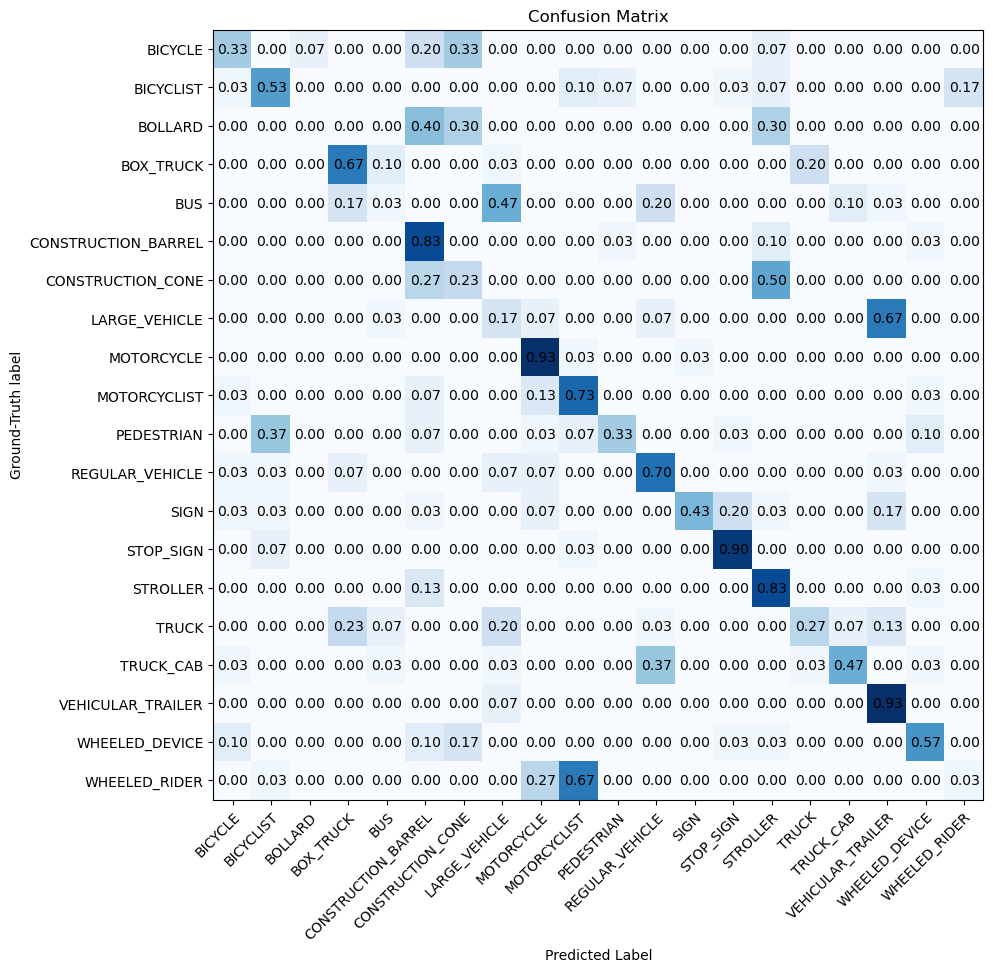

In [34]:
# Generate and plot confusion matrix for baseline model
from vision.part4_analysis import get_confusion_matrix
from vision.utils import plot_confusion_matrix

# Load the trained baseline model (if not already loaded)
model = torch.load('output/Baseline.pt', weights_only=False)

# Generate confusion matrix
confusion_matrix = get_confusion_matrix(
    model=model,
    loader=test_loader,
    num_classes=20,
    normalize=True,
    device='cpu'# Change to 'cuda' if using GPU
)

# Get class labels in the correct order
class_to_idx = test_loader.dataset.class_dict
class_labels = sorted(class_to_idx, key=lambda item: class_to_idx[item])

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix, class_labels)

## Part 3: PointNet

Now that we have a baseline to compare to, we're going to build a simplified version of PointNet which was first published in 2017 by researchers at Stanford University. You can view the original website for this publication [here](https://stanford.edu/~rqi/pointnet/). 

We will be slightly modifying the original architecture. The architecture described in the PointNet publication includes two modules that we will not be implementing. Namely, they are the input transform and the feature transform. We will also not be using our PointNet implementation for semantic segmentation so you can ignore that part of the architecture as well. For an architecture diagram of what we will be implementing, check the project pdf.

**TODO 3**: complete `part3_pointnet.py`, use the architecture diagram in the project pdf for reference.

In [14]:
from tests.test_part3 import test_pointnet
from vision.part3_pointnet import PointNet

In [15]:
print("test_pointnet(): ", verify(test_pointnet))

test_pointnet():  "Correct"


Now that we have a PointNet implementation, lets train our model and see how it does. Fill in the hyper-parameters and give your new model a spin! 

To get full credit for this section, you will need *$\geq$ 60% accuracy* on the test dataset. The TAs were able to consistently achieve this accuracy with ~15 epochs of training.

In [16]:
lr = 0.001
weight_decay = 1e-4
epochs = 10

model = PointNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [17]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|██████████| 213/213 [00:03<00:00, 57.11it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 149.30it/s]



Epoch 1 Stats:
	Training accuracy: 0.3162
	Training loss: 2.0007
	Validation accuracy: 0.4400
	Validation loss: 1.6311

Validation accuracy improved from 0 to 0.4399999976158142
Saving model to PointNet.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:03<00:00, 60.04it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 152.20it/s]



Epoch 2 Stats:
	Training accuracy: 0.5497
	Training loss: 1.3231
	Validation accuracy: 0.4783
	Validation loss: 1.5044

Validation accuracy improved from 0.4399999976158142 to 0.47833332419395447
Saving model to PointNet.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:03<00:00, 58.94it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 146.99it/s]



Epoch 3 Stats:
	Training accuracy: 0.6150
	Training loss: 1.1484
	Validation accuracy: 0.5683
	Validation loss: 1.2254

Validation accuracy improved from 0.47833332419395447 to 0.5683333277702332
Saving model to PointNet.pt


Epoch 4

Training...


100%|██████████| 213/213 [00:03<00:00, 57.09it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 104.06it/s]



Epoch 4 Stats:
	Training accuracy: 0.6668
	Training loss: 1.0113
	Validation accuracy: 0.5750
	Validation loss: 1.4236

Validation accuracy improved from 0.5683333277702332 to 0.574999988079071
Saving model to PointNet.pt


Epoch 5

Training...


100%|██████████| 213/213 [00:03<00:00, 64.81it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 163.72it/s]



Epoch 5 Stats:
	Training accuracy: 0.6856
	Training loss: 0.9276
	Validation accuracy: 0.5383
	Validation loss: 1.5467


Epoch 6

Training...


100%|██████████| 213/213 [00:03<00:00, 64.84it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 164.47it/s]



Epoch 6 Stats:
	Training accuracy: 0.7268
	Training loss: 0.8169
	Validation accuracy: 0.5933
	Validation loss: 1.3272

Validation accuracy improved from 0.574999988079071 to 0.5933333039283752
Saving model to PointNet.pt


Epoch 7

Training...


100%|██████████| 213/213 [00:03<00:00, 63.27it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 163.39it/s]



Epoch 7 Stats:
	Training accuracy: 0.7518
	Training loss: 0.7480
	Validation accuracy: 0.5767
	Validation loss: 1.2927


Epoch 8

Training...


100%|██████████| 213/213 [00:03<00:00, 64.70it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 155.00it/s]



Epoch 8 Stats:
	Training accuracy: 0.7694
	Training loss: 0.6880
	Validation accuracy: 0.6117
	Validation loss: 1.1996

Validation accuracy improved from 0.5933333039283752 to 0.6116666793823242
Saving model to PointNet.pt


Epoch 9

Training...


100%|██████████| 213/213 [00:03<00:00, 58.38it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 159.25it/s]



Epoch 9 Stats:
	Training accuracy: 0.7694
	Training loss: 0.6479
	Validation accuracy: 0.5883
	Validation loss: 1.2815


Epoch 10

Training...


100%|██████████| 213/213 [00:03<00:00, 61.33it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 161.18it/s]


Epoch 10 Stats:
	Training accuracy: 0.7871
	Training loss: 0.6423
	Validation accuracy: 0.5750
	Validation loss: 1.2140




In [18]:
model = torch.load('output/PointNet.pt', weights_only=False)
test_acc, test_loss = test(model, test_loader)

100%|██████████| 38/38 [00:00<00:00, 137.62it/s]

Test accuracy: 0.6117
Test loss: 1.2049


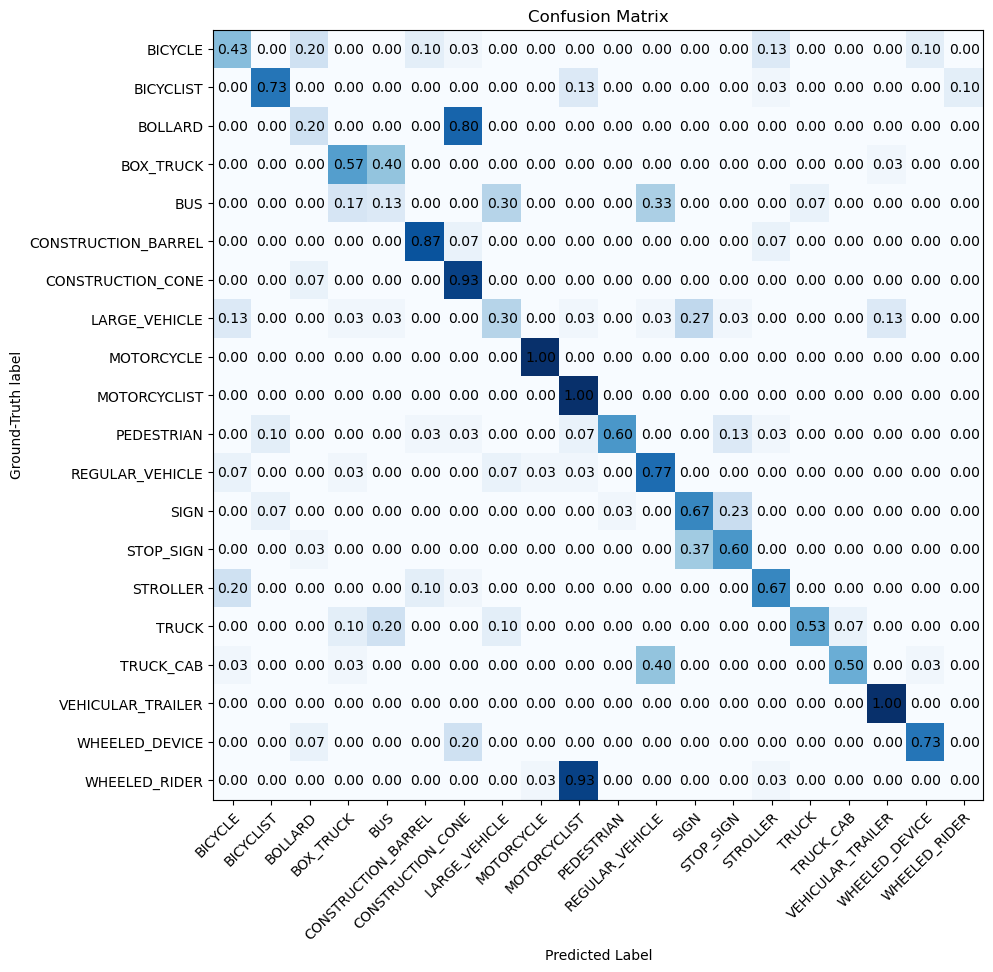

In [35]:
from vision.utils import generate_and_plot_confusion_matrix

# Load the trained PointNet model
model = torch.load('output/PointNet.pt', weights_only=False)

# Generate and plot confusion matrix
generate_and_plot_confusion_matrix(model, test_loader, num_classes=20, device='cpu')

## Part 4: Performance Analysis

Now that we have a trained PointNet model, we can look at how it performs and what its shortcomings are. We are also going to analyze our point clouds to see which parts of them the model deemed to be most important in making its classification decision.

**TODO 4:** complete `part4_analysis.py`

In [19]:
from vision.utils import (
    generate_and_plot_confusion_matrix,
    plot_crit_points_from_file
)
from tests.test_part4 import (
    test_critical_indices,
    test_critical_indices_with_duplicates,
    test_confusion_matrix,
    test_confusion_matrix_normalized
)

In [20]:
print("test_critical_indices(): ", verify(test_critical_indices))
print("test_critical_indices_with_duplicates(): ", verify(test_critical_indices_with_duplicates))
print("test_confusion_matrix(): ", verify(test_confusion_matrix))
print("test_confusion_matrix_normalized(): ", verify(test_confusion_matrix_normalized))

test_critical_indices():  "Correct"
test_critical_indices_with_duplicates():  "Correct"
test_confusion_matrix():  "Correct"
test_confusion_matrix_normalized():  "Correct"


Lets use the confusion matrix to look at which mistakes our model is making most often.

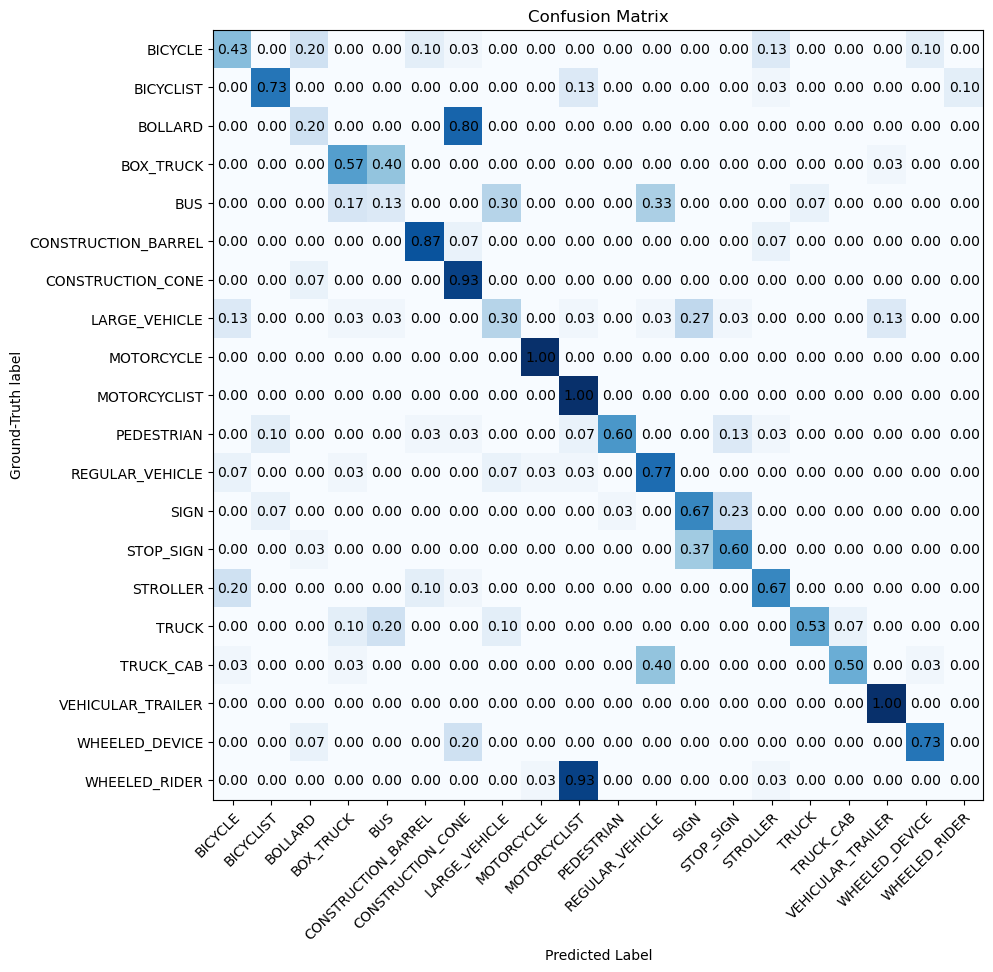

In [21]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

Now lets visualize the critical points calculated by our model for the predestrian clouds from before. Recall that these are the points that contributed to the global feature. Why do you think these were the critical points the model ended up using? (Feel free to use different point clouds for your analysis)

In [36]:
plot_crit_points_from_file(model, 'data/sweeps/MOTORCYCLIST/68.txt', 200)

## Part 5: T-Net (Extra Credit)

Our basic PointNet model does pretty well. But let's see if we can do any better. One proposed solution to improve on the shortcomings of the basic PointNet model is using a T-Net (see pdf for more details). 

**TODO 5:** complete `part5_tnet.py`

In [23]:
from vision.part5_tnet import PointNetTNet
from tests.test_part5 import (
    test_tnet_shapes,
    test_pointnet_tnet
)

In [24]:
print("test_tnet_shapes(): ", verify(test_tnet_shapes))
print("test_pointnet_tnet(): ", verify(test_pointnet_tnet))

test_tnet_shapes():  "Correct"
test_pointnet_tnet():  "Correct"


Let's check out how our model performs now that we added a T-Net.

To get full credit for this section, you will need *$\geq$ 65% accuracy* on the test dataset. The TAs were able to achieve this accuracy with ~15 epochs of training. 

*Hint 1: You may need to play around with the number of layers in the T-Net*

*Hint 2: T-Net is sensitive to the initialization so you should try training the same model more than once*

In [25]:
lr = 0.001
weight_decay = 1e-5
epochs = 20

model = PointNetTNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [26]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|██████████| 213/213 [00:06<00:00, 32.78it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 88.61it/s]



Epoch 1 Stats:
	Training accuracy: 0.2888
	Training loss: 2.0563
	Validation accuracy: 0.3783
	Validation loss: 1.8438

Validation accuracy improved from 0 to 0.37833333015441895
Saving model to PointNetTNet.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:06<00:00, 33.66it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 81.81it/s]



Epoch 2 Stats:
	Training accuracy: 0.5215
	Training loss: 1.4274
	Validation accuracy: 0.5133
	Validation loss: 1.5592

Validation accuracy improved from 0.37833333015441895 to 0.5133333206176758
Saving model to PointNetTNet.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:06<00:00, 32.81it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 88.65it/s]



Epoch 3 Stats:
	Training accuracy: 0.5785
	Training loss: 1.2534
	Validation accuracy: 0.5000
	Validation loss: 1.3692


Epoch 4

Training...


100%|██████████| 213/213 [00:06<00:00, 33.04it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 76.64it/s]



Epoch 4 Stats:
	Training accuracy: 0.6547
	Training loss: 1.0337
	Validation accuracy: 0.5283
	Validation loss: 1.4246

Validation accuracy improved from 0.5133333206176758 to 0.528333306312561
Saving model to PointNetTNet.pt


Epoch 5

Training...


100%|██████████| 213/213 [00:06<00:00, 33.64it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 87.44it/s]



Epoch 5 Stats:
	Training accuracy: 0.7032
	Training loss: 0.8849
	Validation accuracy: 0.5817
	Validation loss: 1.3506

Validation accuracy improved from 0.528333306312561 to 0.5816666483879089
Saving model to PointNetTNet.pt


Epoch 6

Training...


100%|██████████| 213/213 [00:06<00:00, 32.78it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 88.03it/s]



Epoch 6 Stats:
	Training accuracy: 0.7282
	Training loss: 0.8002
	Validation accuracy: 0.6150
	Validation loss: 1.4083

Validation accuracy improved from 0.5816666483879089 to 0.6150000095367432
Saving model to PointNetTNet.pt


Epoch 7

Training...


100%|██████████| 213/213 [00:06<00:00, 32.48it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 87.28it/s]



Epoch 7 Stats:
	Training accuracy: 0.7621
	Training loss: 0.7276
	Validation accuracy: 0.5300
	Validation loss: 1.2998


Epoch 8

Training...


100%|██████████| 213/213 [00:06<00:00, 33.23it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 88.90it/s]



Epoch 8 Stats:
	Training accuracy: 0.7644
	Training loss: 0.7200
	Validation accuracy: 0.5750
	Validation loss: 1.3081


Epoch 9

Training...


100%|██████████| 213/213 [00:06<00:00, 33.46it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 86.70it/s]



Epoch 9 Stats:
	Training accuracy: 0.7844
	Training loss: 0.6222
	Validation accuracy: 0.6750
	Validation loss: 1.1067

Validation accuracy improved from 0.6150000095367432 to 0.675000011920929
Saving model to PointNetTNet.pt


Epoch 10

Training...


100%|██████████| 213/213 [00:06<00:00, 33.39it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 86.93it/s]



Epoch 10 Stats:
	Training accuracy: 0.7812
	Training loss: 0.6378
	Validation accuracy: 0.5883
	Validation loss: 1.4481


Epoch 11

Training...


100%|██████████| 213/213 [00:06<00:00, 33.44it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 87.35it/s]



Epoch 11 Stats:
	Training accuracy: 0.8006
	Training loss: 0.5810
	Validation accuracy: 0.5633
	Validation loss: 1.3839


Epoch 12

Training...


100%|██████████| 213/213 [00:06<00:00, 33.26it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 87.50it/s]



Epoch 12 Stats:
	Training accuracy: 0.8226
	Training loss: 0.5319
	Validation accuracy: 0.5883
	Validation loss: 1.2688


Epoch 13

Training...


100%|██████████| 213/213 [00:06<00:00, 32.67it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 85.97it/s]



Epoch 13 Stats:
	Training accuracy: 0.8309
	Training loss: 0.4908
	Validation accuracy: 0.6183
	Validation loss: 1.2684


Epoch 14

Training...


100%|██████████| 213/213 [00:06<00:00, 32.94it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 84.19it/s]



Epoch 14 Stats:
	Training accuracy: 0.8426
	Training loss: 0.4837
	Validation accuracy: 0.6483
	Validation loss: 1.1825


Epoch 15

Training...


100%|██████████| 213/213 [00:06<00:00, 32.80it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 87.45it/s]



Epoch 15 Stats:
	Training accuracy: 0.8532
	Training loss: 0.4457
	Validation accuracy: 0.6217
	Validation loss: 1.2823


Epoch 16

Training...


100%|██████████| 213/213 [00:06<00:00, 32.74it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 88.35it/s]



Epoch 16 Stats:
	Training accuracy: 0.8512
	Training loss: 0.4511
	Validation accuracy: 0.6467
	Validation loss: 1.2621


Epoch 17

Training...


100%|██████████| 213/213 [00:06<00:00, 32.79it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 86.80it/s]



Epoch 17 Stats:
	Training accuracy: 0.8600
	Training loss: 0.4224
	Validation accuracy: 0.6250
	Validation loss: 1.3014


Epoch 18

Training...


100%|██████████| 213/213 [00:06<00:00, 32.43it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 85.99it/s]



Epoch 18 Stats:
	Training accuracy: 0.8526
	Training loss: 0.4439
	Validation accuracy: 0.6033
	Validation loss: 1.5037


Epoch 19

Training...


100%|██████████| 213/213 [00:06<00:00, 32.94it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 86.39it/s]



Epoch 19 Stats:
	Training accuracy: 0.8688
	Training loss: 0.3988
	Validation accuracy: 0.6000
	Validation loss: 1.5136


Epoch 20

Training...


100%|██████████| 213/213 [00:06<00:00, 32.66it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 87.60it/s]


Epoch 20 Stats:
	Training accuracy: 0.8621
	Training loss: 0.4125
	Validation accuracy: 0.6333
	Validation loss: 1.4110




In [30]:
model = torch.load('output/PointNetTNet.pt', weights_only=False)
test_acc, test_loss = test(model, test_loader)

100%|██████████| 38/38 [00:00<00:00, 83.53it/s]

Test accuracy: 0.6750
Test loss: 1.1210


Lets take a look at how the addition of positional encoding improved on the performance of our original PointNet model. Which classes does the positional encoding help the most with? Which ones does it not really seem to make much of a difference for? Why?

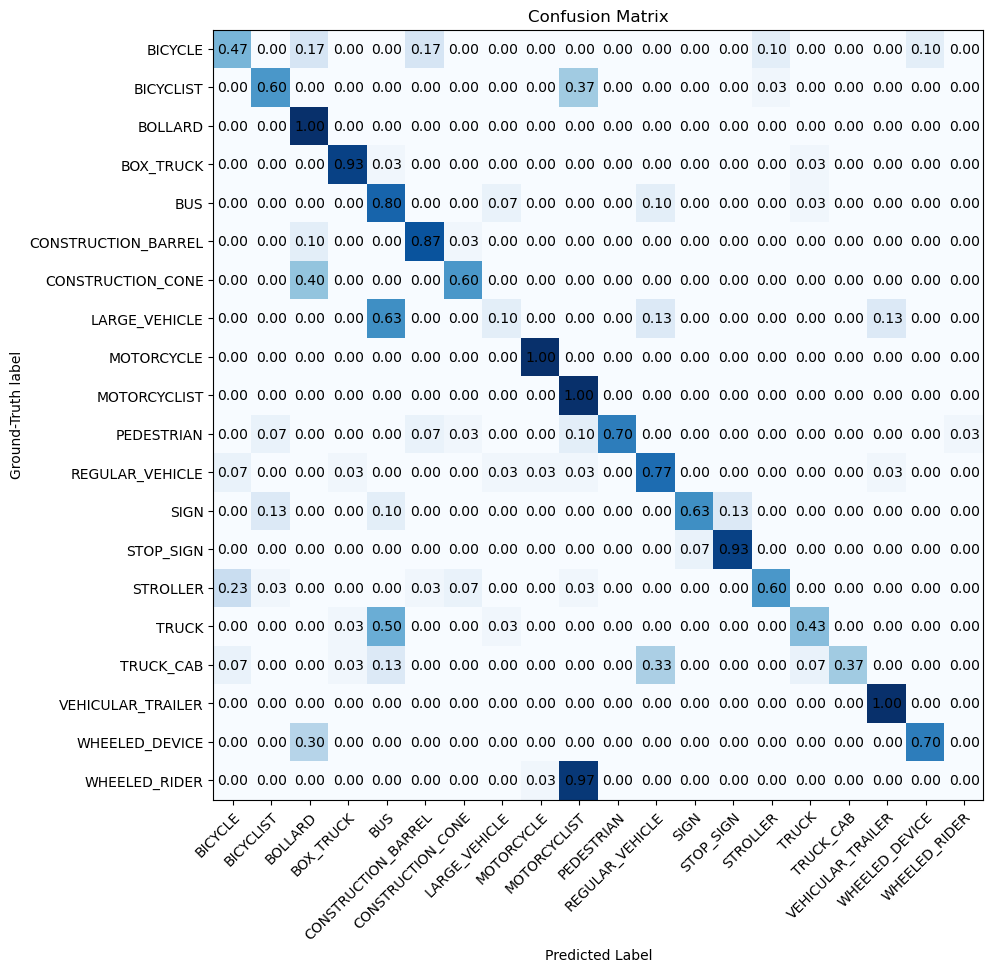

In [28]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

In [29]:
plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/11.txt', 200)